# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [235]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 1. Load Dataset

In [157]:
df = pd.read_csv('./data/final_0509.csv')
# 한국 일일확진자 변수 제거
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [158]:
for i in list(df.columns):
    if i[0:2] == 'KR':
        print(i)

KR


In [159]:
df.tail()

,Date,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,...,DE_roam,JP_roam,TH_roam,VN_roam,US_roam,CN_roam,news,covid_tr,coro_tr,target
100,2020-05-01,0,0,476,284,7933,6,0,34037,557,...,6,119,32,58,108,196,1104.0,48.0,18.0,8.0
101,2020-05-02,0,0,445,156,9623,13,3,29078,561,...,26,158,15,17,132,84,732.0,43.0,18.0,8.0
102,2020-05-03,4,0,335,295,10633,8,4,25501,564,...,18,142,22,52,92,121,821.0,55.0,18.0,10.0
103,2020-05-04,6,0,199,262,10581,3,2,22335,567,...,30,122,6,91,66,88,1331.0,30.0,17.0,8.0
104,2020-05-05,0,0,318,199,10102,2,0,23976,462,...,18,161,26,49,123,94,793.0,30.0,17.0,3.0


## lag 변수 생성

In [160]:
df.Date = pd.to_datetime(df.Date)
#df['dayofweek'] = df['Date'].dt.dayofweek
df.set_index('Date', inplace=True)

In [156]:
# lag_col = ['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'N_AMERICA_conf', 'NZ_conf',
#        'EURO_roam', 'CHINA_roam', 'ASIA_roam', 'N_AMERICA_roam', 'NZ_roam',
#        'TARGET', 'NEWS', 'covid_tr', 'coro_tr']

In [161]:
lag_col= list(df.columns)

In [162]:
lag_amount = 3

for col in lag_col:
    for i in range(lag_amount):
        df['{0}_lag{1}'.format(col,i+1)] = df['{}'.format(col)].shift(i+1)
    
df.dropna(inplace=True)

In [163]:
df.tail()

,MM_conf,LA_conf,NL_conf,PH_conf,RU_conf,KR,TW_conf,US_conf,AE_conf,GB_conf,...,news_lag3,covid_tr_lag1,covid_tr_lag2,covid_tr_lag3,coro_tr_lag1,coro_tr_lag2,coro_tr_lag3,target_lag1,target_lag2,target_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0,0,476,284,7933,6,0,34037,557,6204,...,1763.0,43.0,63.0,59.0,18.0,18.0,18.0,4.0,5.0,12.0
2020-05-02,0,0,445,156,9623,13,3,29078,561,4815,...,1117.0,48.0,43.0,63.0,18.0,18.0,18.0,8.0,4.0,5.0
2020-05-03,4,0,335,295,10633,8,4,25501,564,4342,...,1266.0,43.0,48.0,43.0,18.0,18.0,18.0,8.0,8.0,4.0
2020-05-04,6,0,199,262,10581,3,2,22335,567,3990,...,1104.0,55.0,43.0,48.0,18.0,18.0,18.0,10.0,8.0,8.0
2020-05-05,0,0,318,199,10102,2,0,23976,462,4411,...,732.0,30.0,55.0,43.0,17.0,18.0,18.0,8.0,10.0,8.0


# Data Exploration

In [164]:
# 결측치 확인
df.isnull().sum().sum()

0

In [165]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (102, 332)
target feature shape: (102,)


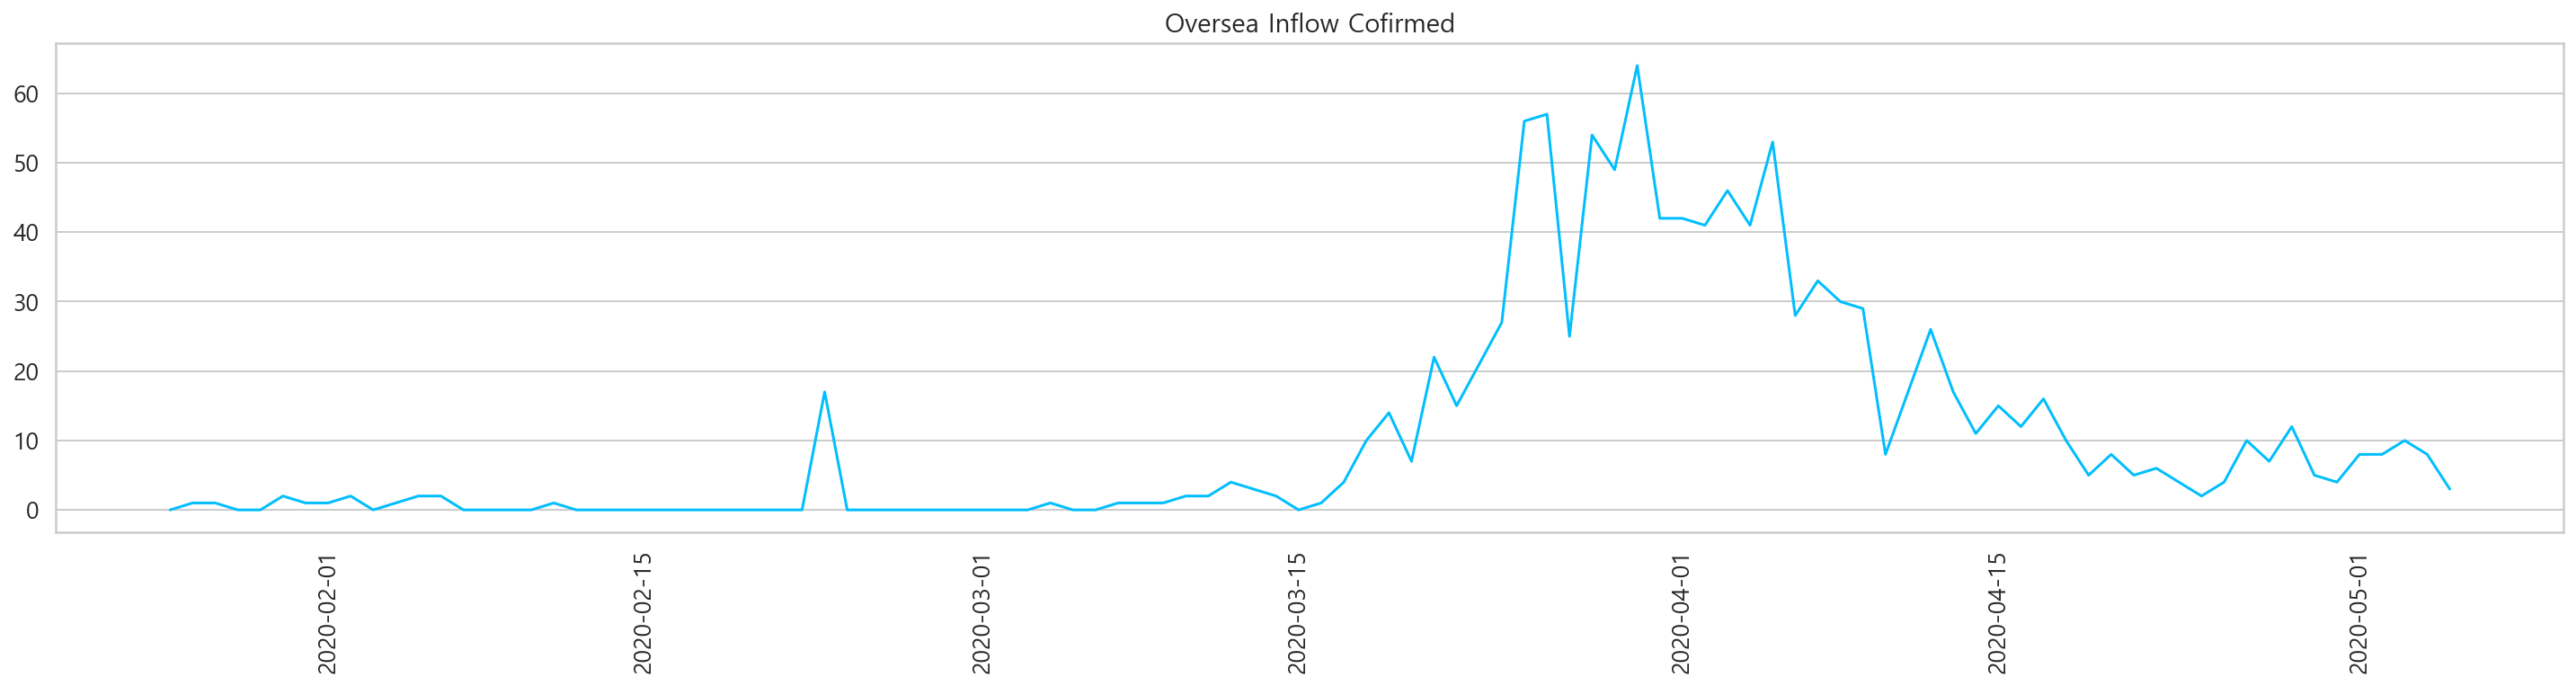

In [166]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

## Feature Selection

In [173]:
X_cols = list(df.columns)
X_cols.remove('target')

In [174]:
# 테스트 데이터 수
test_data_size = 14

X = df[X_cols]
y = df['target']

In [175]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [176]:
rf = RandomForestRegressor()
rf.fit(X, y)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf.score(X_train, y_train)))
print("Score on test set : {:.3f}".format(rf.score(X_test, y_test)))

Score on training set : 0.975
Score on test set : 0.787


In [177]:
param_grid = { 
    'n_estimators': [100, 110, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8],
    'min_samples_split' : [6,7,8,54,56]
}

In [178]:
# grid search
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [179]:
CV_rfc

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [181]:
CV_rfc.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [182]:
CV_rfc.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 6,
 'n_estimators': 200}

In [184]:
# parameter 설정후에 다시 진행
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=6, max_features='auto')
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [185]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = list(X.columns)
df_importance['Importance'] = rf.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
117,AU_conf_lag3,0.184
175,NZ_conf_lag1,0.161
198,TH_conf_lag3,0.095
176,NZ_conf_lag2,0.089
31,NZ_conf,0.046
...,...,...
256,CZ_roam_lag1,0.000
258,CZ_roam_lag3,0.000
262,AT_roam_lag1,0.000
276,AE_roam_lag3,0.000


Text(0, 0.5, '변수')

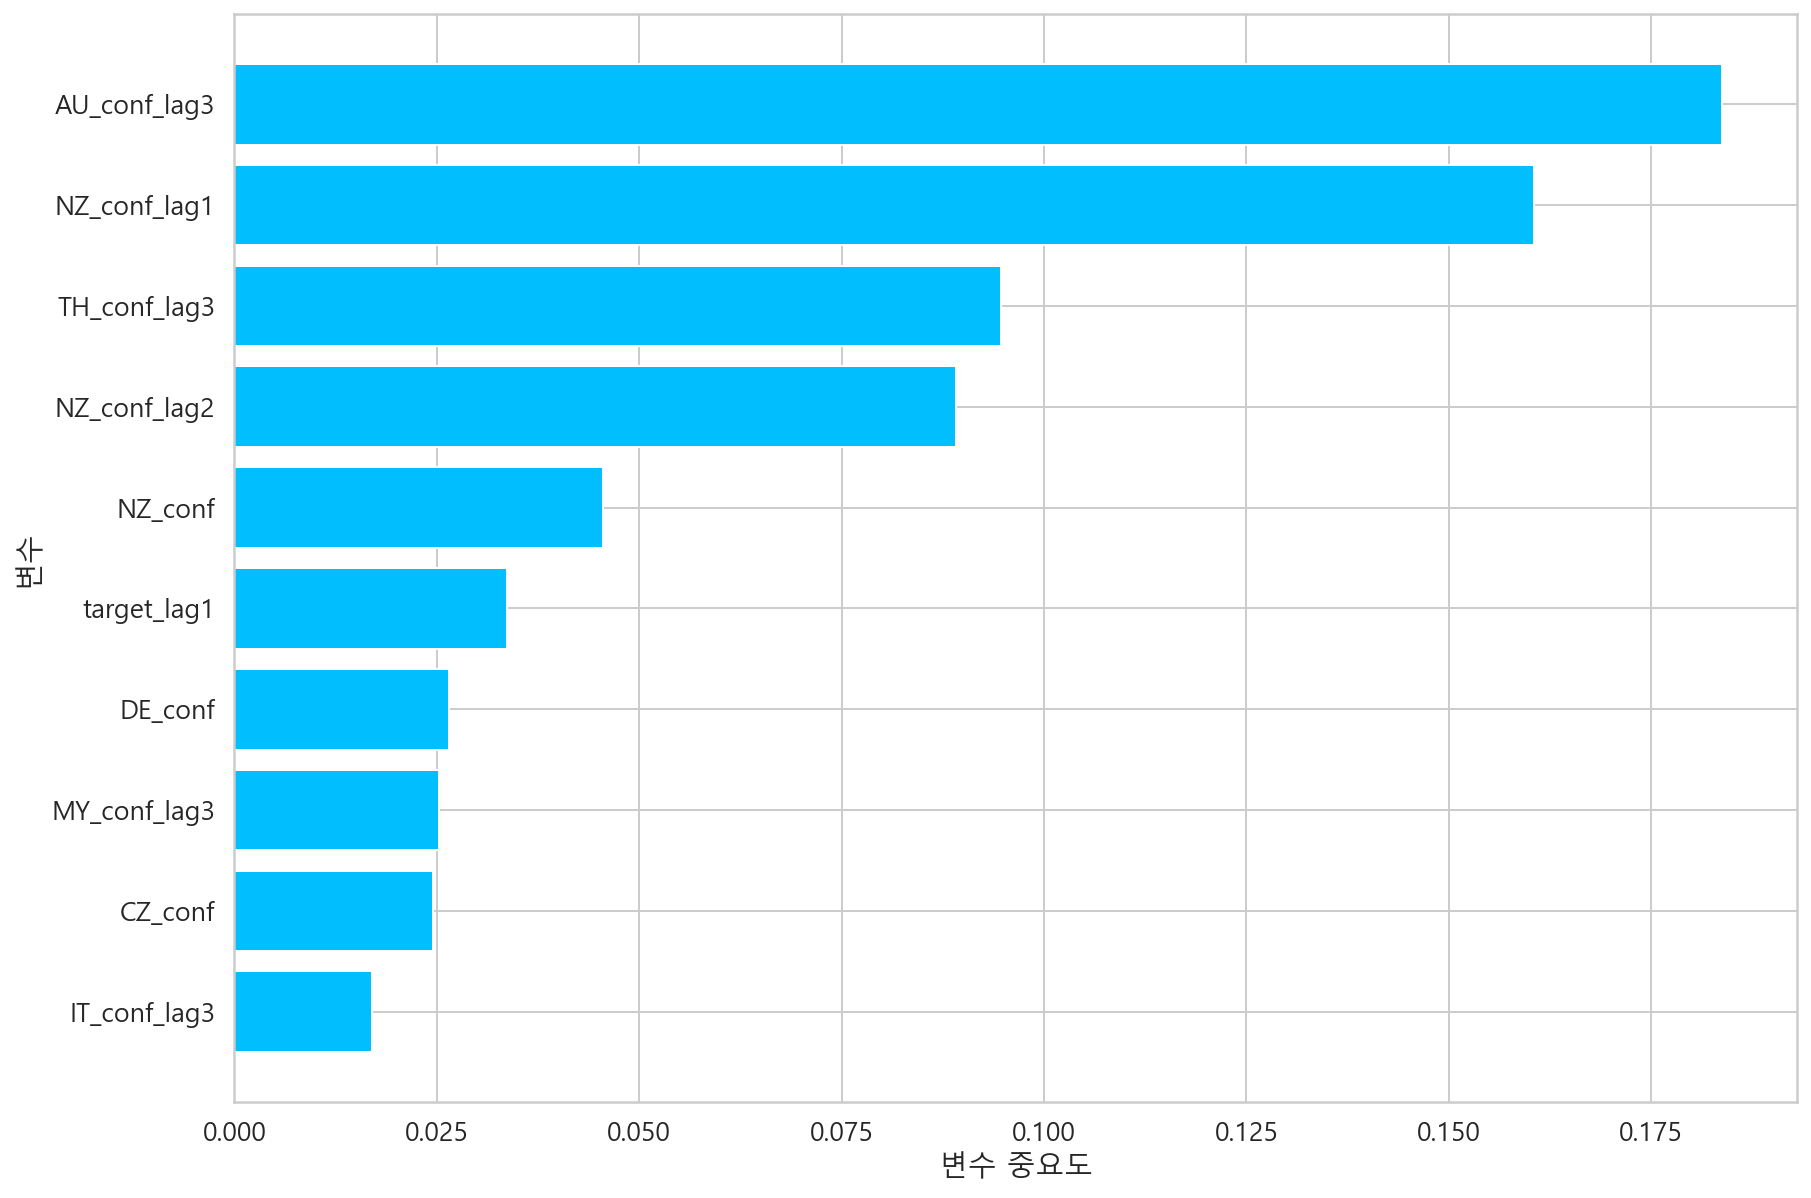

In [263]:
# 설명변수 중요도 그래
# 중요도가 높은 변수를 상위에 그림
# 상위 10개 확인
df_importance1 = df_importance.head(10)
df_importance1.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance1))
plt.barh(y = coordinates,
        width = df_importance1['Importance'])
plt.yticks(coordinates, df_importance1['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

In [264]:
#df_importance1=df_importance.head(12)

In [265]:
new_x_cols=list(df_importance1['Feature'])

In [186]:
#df_importance.to_csv('feature_importance.csv')

# ARIMA Model

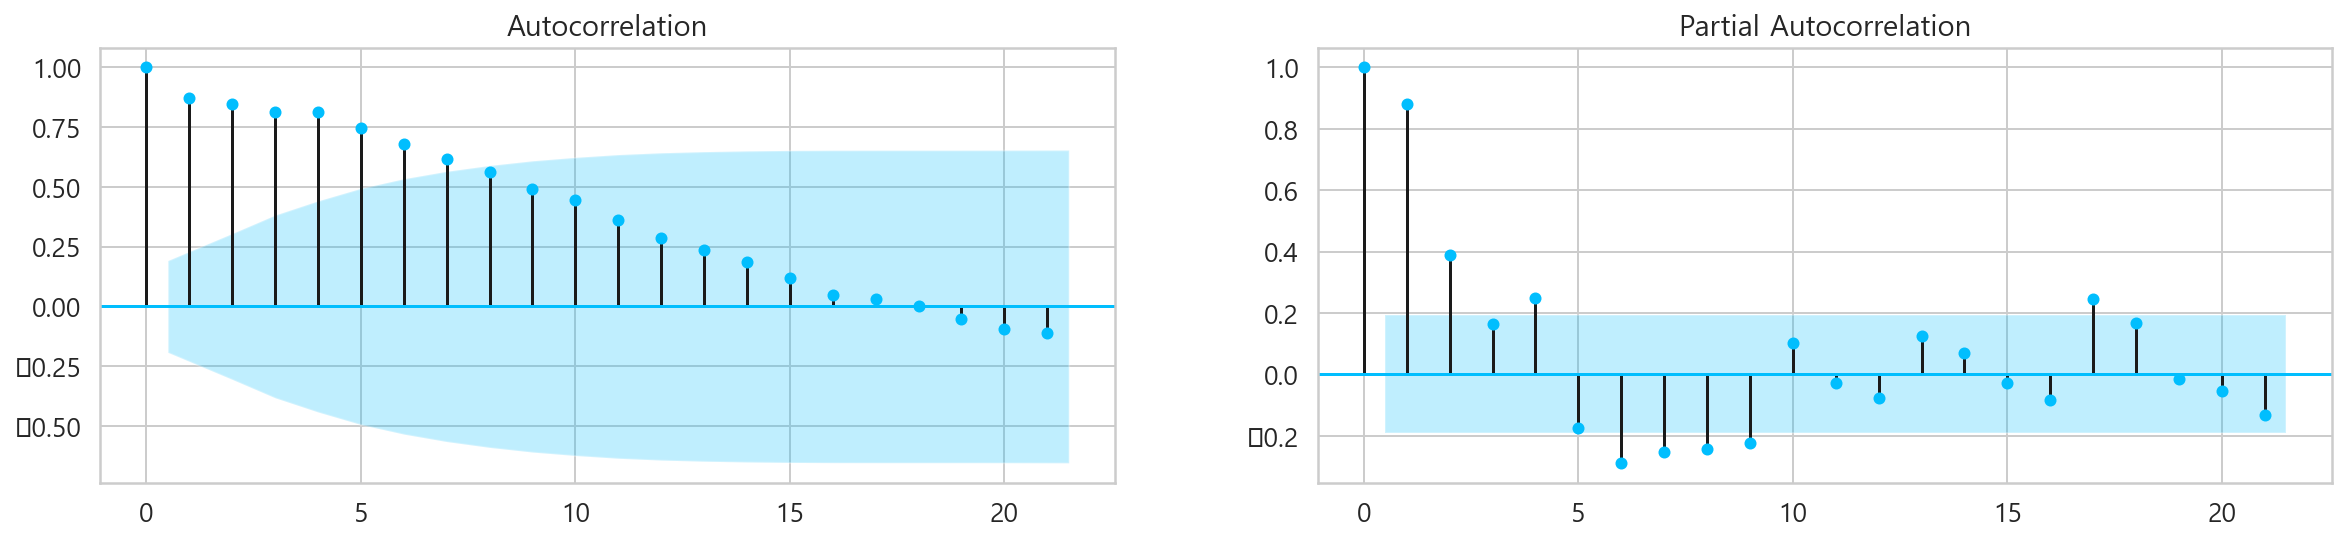

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,4))

plot_acf(df['target'], ax=ax[0])
plot_pacf(df['target'],ax=ax[1])
plt.show()

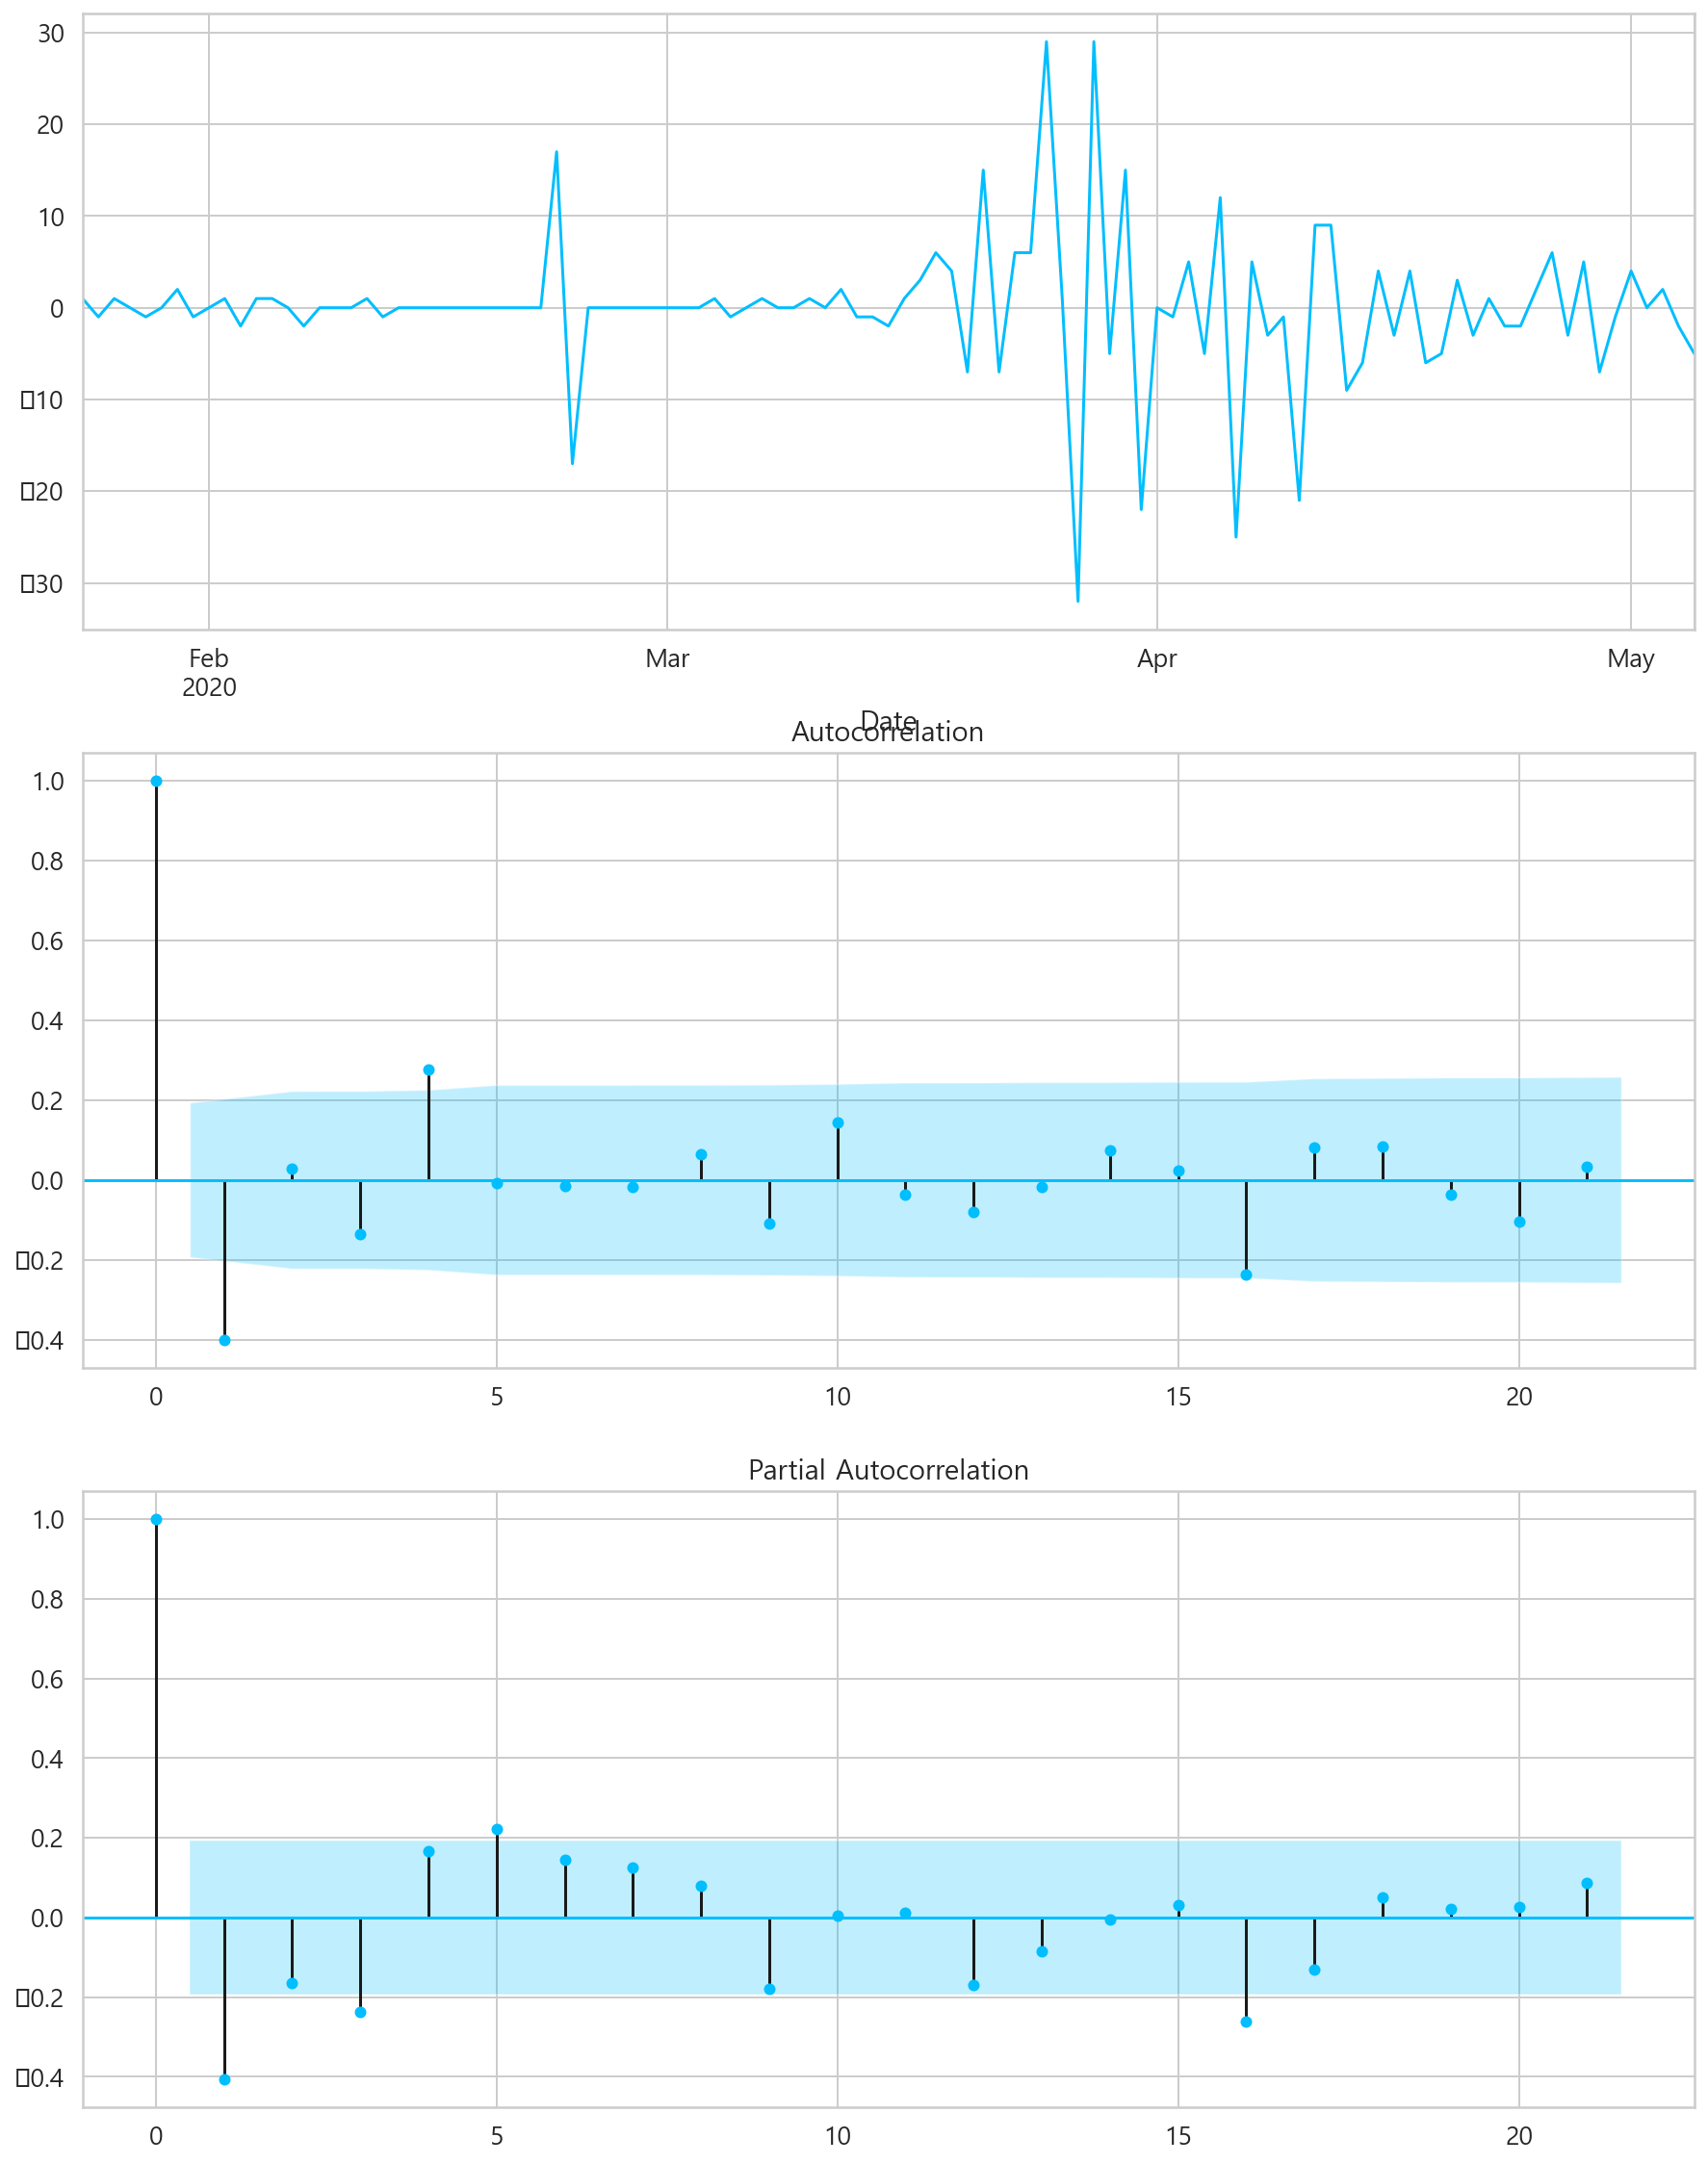

In [30]:
diff_1=df['target'].diff(periods=1).iloc[1:]
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
diff_1.plot(ax=ax[0])
plot_acf(diff_1, ax=ax[1])
plot_pacf(diff_1, ax=ax[2])
plt.show()

## Create Model

In [266]:
# X_cols = list(df.columns)
# X_cols.remove('target')
# new_x_cols = ['RU_conf_lag1',   'CA_conf_lag1',   'news_lag1',   'CA_conf',   'AU_conf']

In [267]:
new_x_cols

['IT_conf_lag3',
 'CZ_conf',
 'MY_conf_lag3',
 'DE_conf',
 'target_lag1',
 'NZ_conf',
 'NZ_conf_lag2',
 'TH_conf_lag3',
 'NZ_conf_lag1',
 'AU_conf_lag3']

In [268]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분

# 앞의 40개는 지우기
# X = df[63:][X_cols]
# y = df[63:]['TARGET']

X = df[new_x_cols]
y = df['target']

In [269]:
# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size], y[-test_data_size:]

In [270]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(endog=y_train, exog=X_train,order=(0,1,1), dates=df.index)
model_fit = model.fit(trend='nc',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:                   87
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -260.007
Method:                       css-mle   S.D. of innovations              4.778
Date:                Sun, 10 May 2020   AIC                            544.015
Time:                        02:12:51   BIC                            573.605
Sample:                    01-26-2020   HQIC                           555.930
                         - 05-05-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
IT_conf_lag3       0.0003      0.000      0.662      0.508      -0.001       0.001
CZ_conf           -0.0214      0.017     -1.271      0.204      -0.054       0.012
MY_conf_lag3       0.0174      0.016

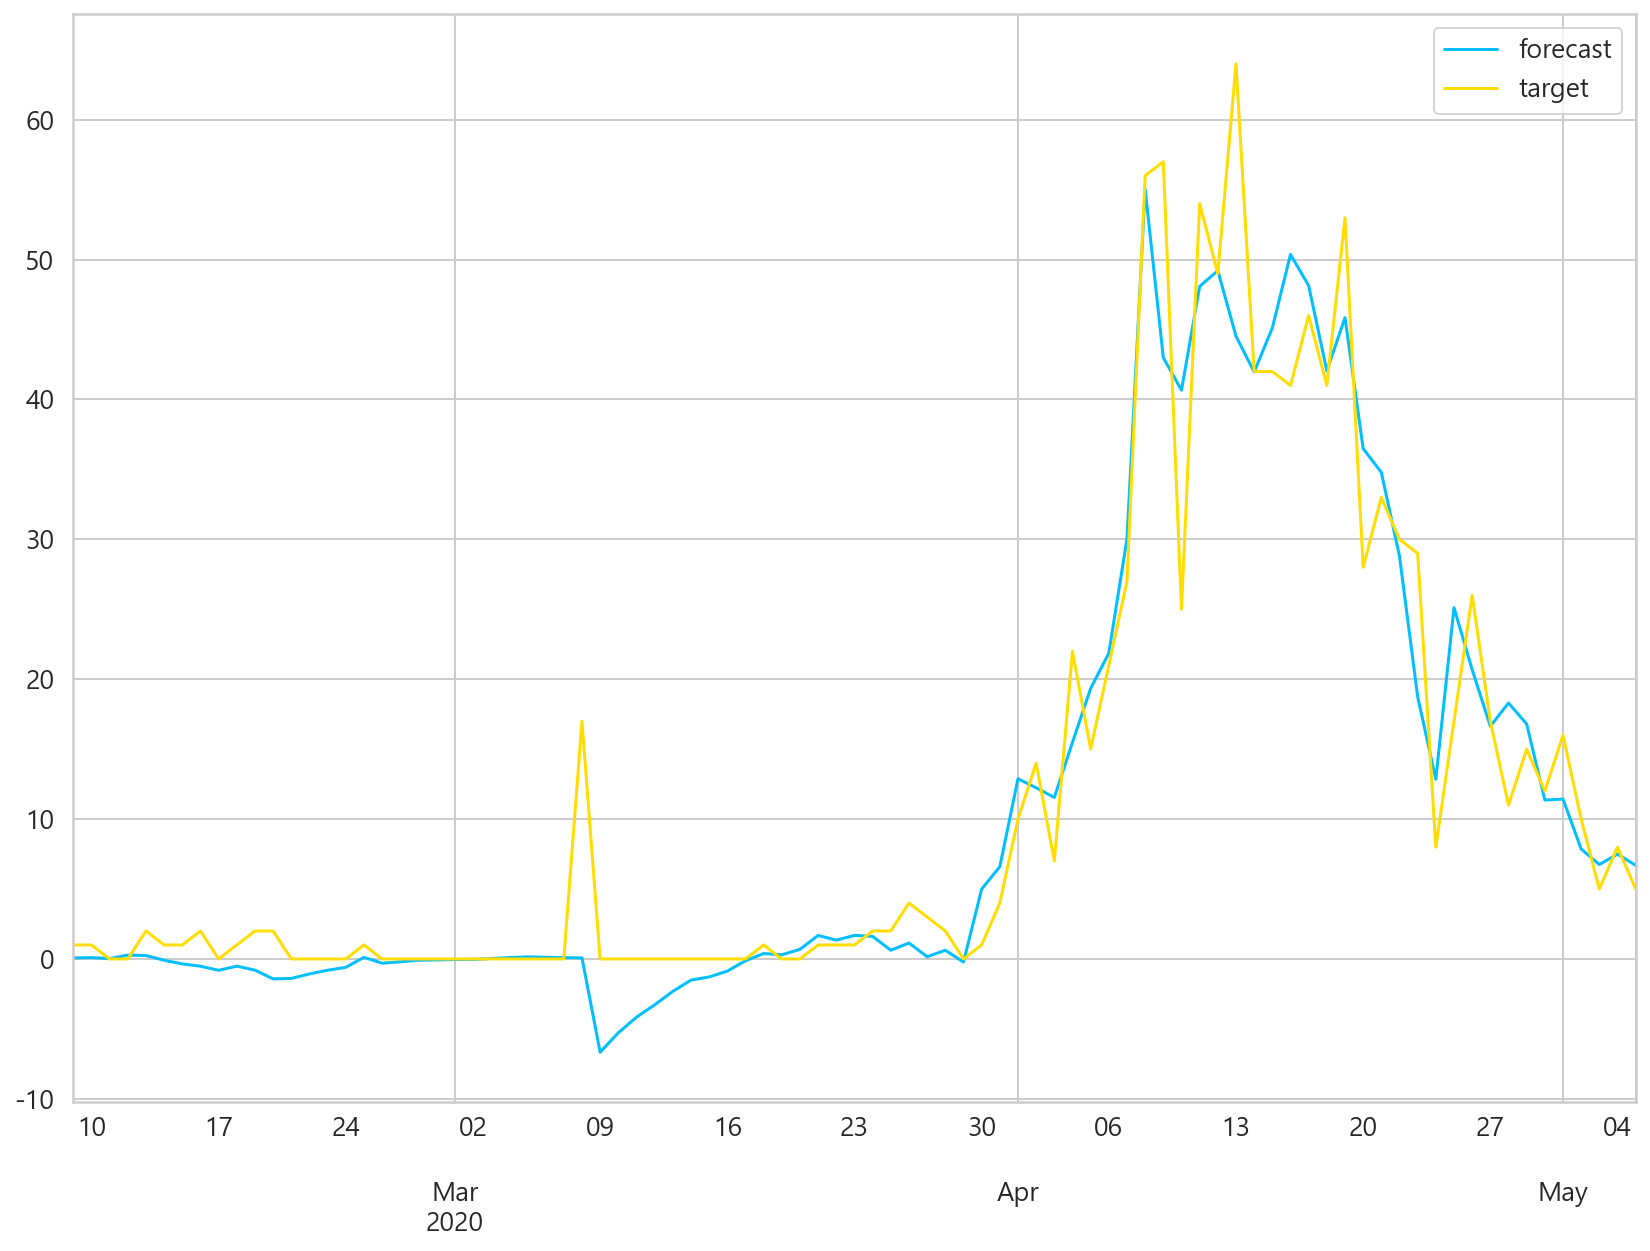

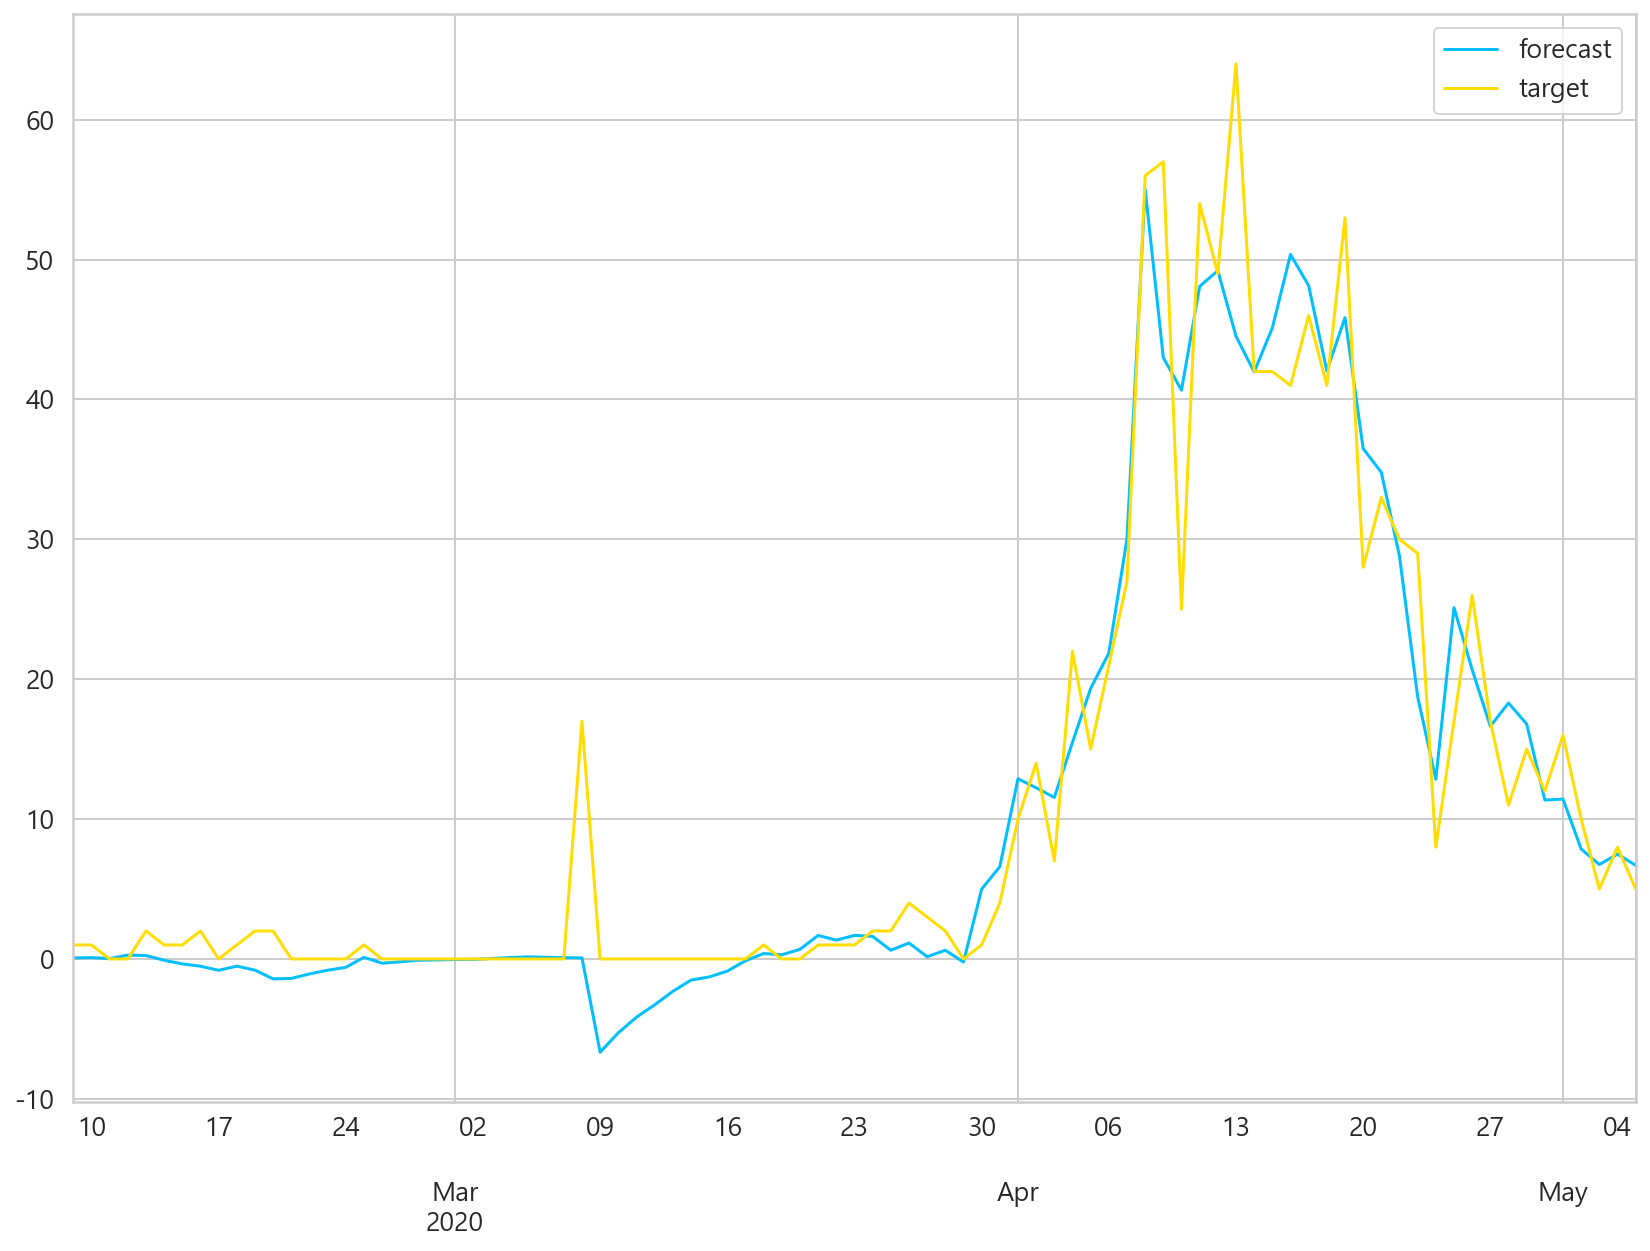

In [271]:
model_fit.plot_predict()

In [272]:
fore = model_fit.forecast(exog=X_test, steps=14)
print(fore[0])

[ 8.33471962  8.44087915  9.02233707 10.53813257 10.61748509 11.39205194
  9.02198706  3.9528612   1.54733571  1.50331211  0.03354425 -3.04163557
 -7.3480227  -9.70370893]


In [273]:
arima_fore = pd.DataFrame(index = y_test.index, data=fore[0], columns=['ARIMA'])

In [274]:
arima_fore

,ARIMA
Date,
2020-04-22,8.334720
2020-04-23,8.440879
2020-04-24,9.022337
2020-04-25,10.538133
2020-04-26,10.617485
2020-04-27,11.392052
2020-04-28,9.021987
2020-04-29,3.952861
2020-04-30,1.547336


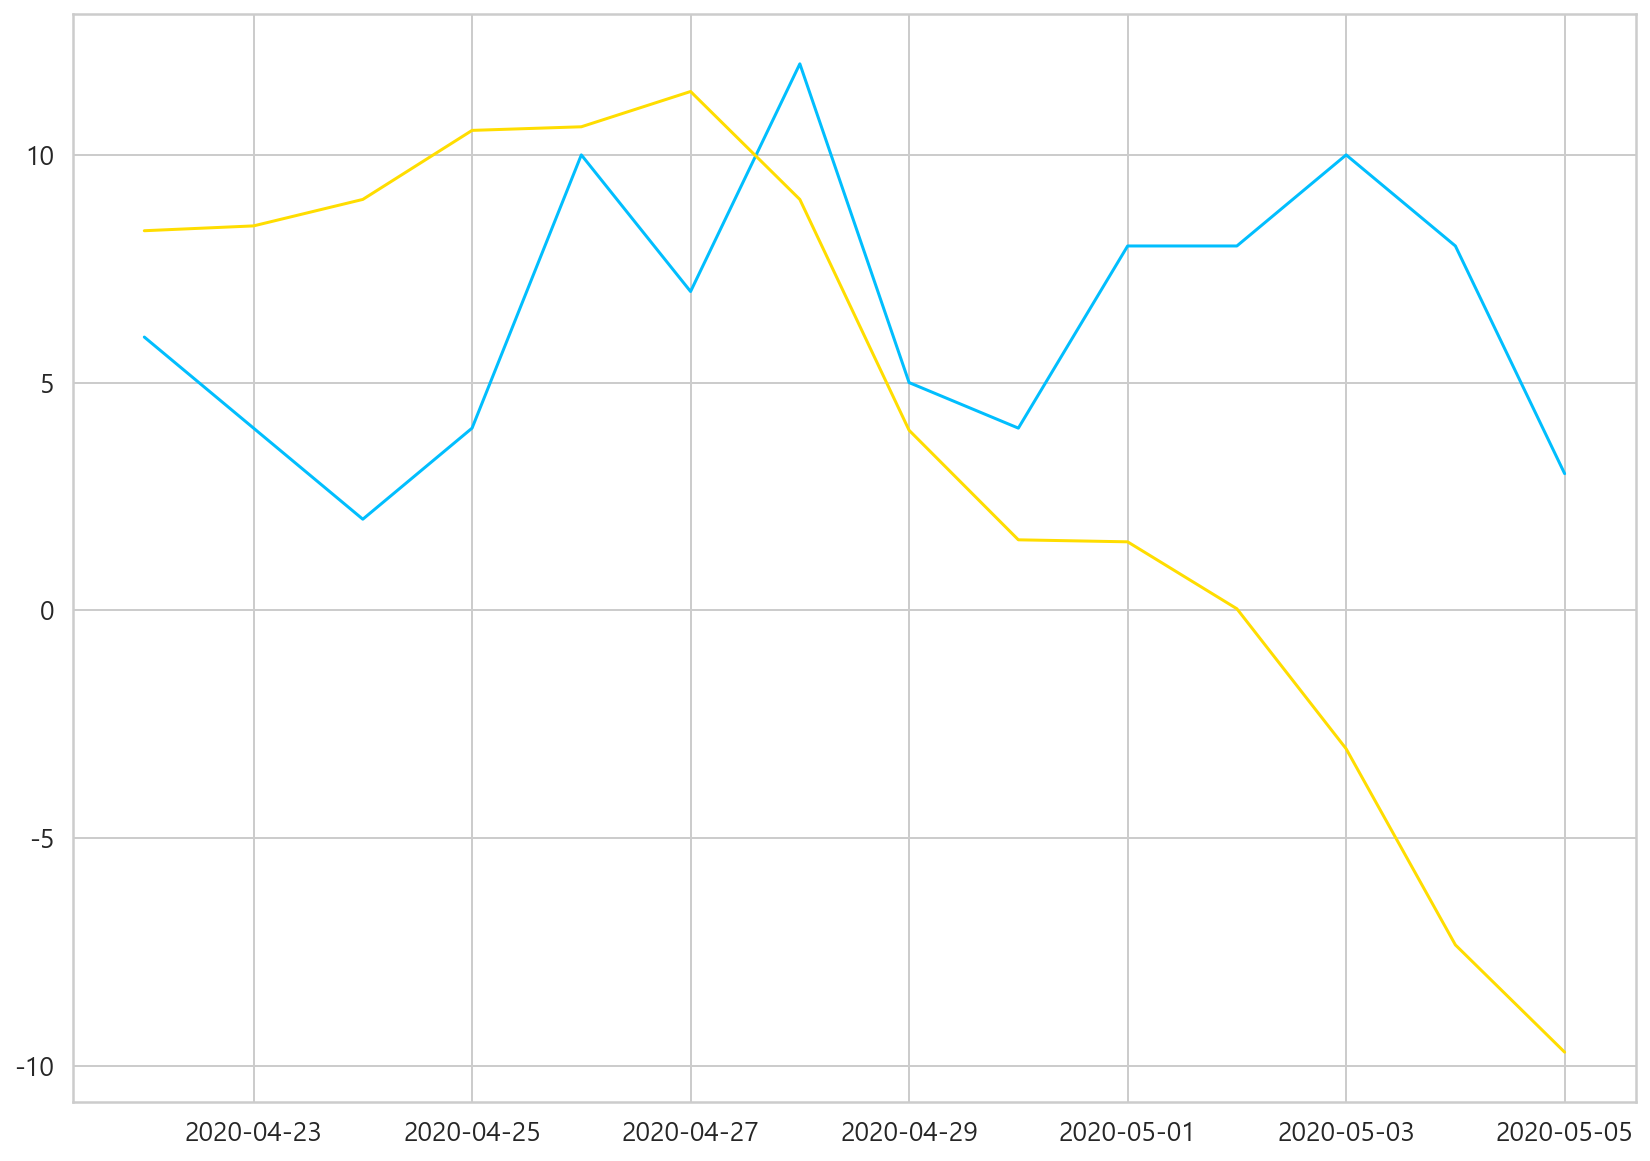

In [275]:
plt.plot(y_test, label='Real')
plt.plot(arima_fore, label='Pred')

# LSTM Model

In [510]:
new_x_cols = ['RU_conf_lag1',   'CA_conf_lag1',   'news_lag1',   'CA_conf',   'AU_conf']

In [323]:
new_x_cols = list(df_importance1['Feature'])

In [324]:
X_cols = list(df.columns)
X_cols.remove('target')

In [327]:
# 테스트 데이터 수
test_data_size = 14
# X변수들과 y변수 구분

# 앞의 40개는 지우기
# X = df[63:][X_cols]
# y = df[63:]['TARGET']

X = df[X_cols]
y = df['target']

In [328]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [329]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (88, 331)
test set :  (14, 331)


In [330]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp=array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
        
    return res

In [331]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [332]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [333]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([88, 1, 331])
X_test : torch.Size([14, 1, 331])
y_train : torch.Size([88, 1])
y_test : torch.Size([14, 1])


# Building a Model

In [334]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.1
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [335]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {round(loss.item(),4)} test loss: {round(test_loss.item(),4)}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [336]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=64
n_layers=4
lr=1e-4
num_epochs=200

In [337]:
# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.1072 test loss: 0.016
Epoch 10 train loss: 0.0925 test loss: 0.0091
Epoch 20 train loss: 0.0793 test loss: 0.0044
Epoch 30 train loss: 0.0656 test loss: 0.0023
Epoch 40 train loss: 0.0502 test loss: 0.0051
Epoch 50 train loss: 0.0343 test loss: 0.0166
Epoch 60 train loss: 0.0227 test loss: 0.0386
Epoch 70 train loss: 0.0178 test loss: 0.0486
Epoch 80 train loss: 0.0134 test loss: 0.0225
Epoch 90 train loss: 0.0102 test loss: 0.0147
Epoch 100 train loss: 0.0078 test loss: 0.0083
Epoch 110 train loss: 0.0072 test loss: 0.0047
Epoch 120 train loss: 0.007 test loss: 0.003
Epoch 130 train loss: 0.0069 test loss: 0.0027
Epoch 140 train loss: 0.0068 test loss: 0.0024
Epoch 150 train loss: 0.0068 test loss: 0.0023
Epoch 160 train loss: 0.0067 test loss: 0.0022
Epoch 170 train loss: 0.0067 test loss: 0.0022
Epoch 180 train loss: 0.0067 test loss: 0.0022
Epoch 190 train loss: 0.0066 test loss: 0.0021


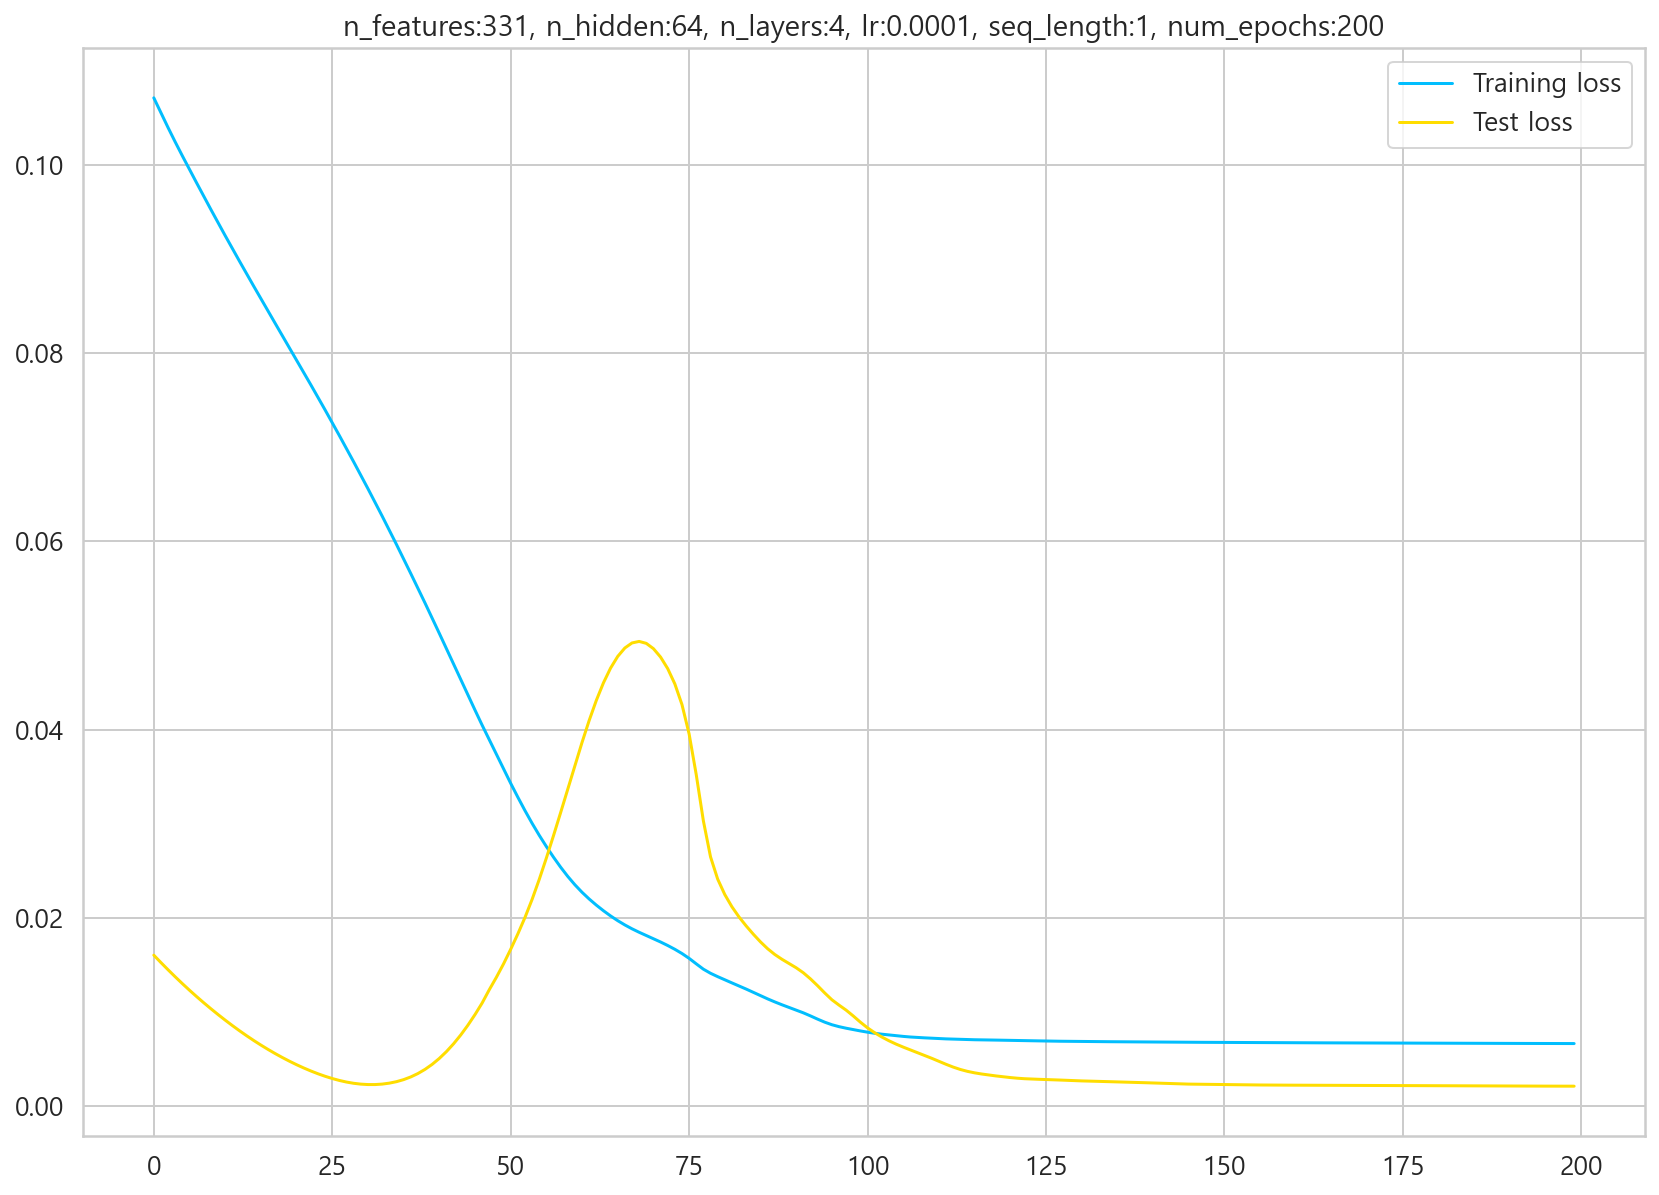

In [338]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

# Predicting daily cases

In [339]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [340]:
preds

[0.11690758168697357,
 0.11724618077278137,
 0.1168505996465683,
 0.11522847414016724,
 0.11415785551071167,
 0.11189964413642883,
 0.110542431473732,
 0.11027377843856812,
 0.1090850979089737,
 0.1105118989944458,
 0.11194850504398346,
 0.11333794891834259,
 0.11357821524143219,
 0.11508242785930634]

In [341]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [342]:
pred_values

array([[7.48208523],
       [7.50375557],
       [7.47843838],
       [7.37462234],
       [7.30610275],
       [7.16157722],
       [7.07471561],
       [7.05752182],
       [6.98144627],
       [7.07276154],
       [7.16470432],
       [7.25362873],
       [7.26900578],
       [7.36527538]])

In [343]:
# # 예측값 반올림
# import math

# pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
# pred_values_ceiled

In [344]:
pred_values_ceiled  = list(pred_values.flatten())

In [345]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [346]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [347]:
# score_table['True_1'] = score_table['True'].diff()
# score_table['Pred_1'] = score_table['Pred'].diff()
# score_table['Pred_1'].iloc[0] = 0
# score_table['True_1'].iloc[0] = 0

In [349]:
score_table['ARIMA'] = arima_fore['ARIMA'].values
score_table['mean'] = (score_table['Pred'] + score_table['ARIMA'])/2

In [350]:
score_table

,True,Pred,ARIMA,mean
0,6.0,7.482085,8.334720,7.908402
1,4.0,7.503756,8.440879,7.972317
2,2.0,7.478438,9.022337,8.250388
3,4.0,7.374622,10.538133,8.956377
4,10.0,7.306103,10.617485,8.961794
5,7.0,7.161577,11.392052,9.276815
6,12.0,7.074716,9.021987,8.048351
7,5.0,7.057522,3.952861,5.505192
8,4.0,6.981446,1.547336,4.264391
9,8.0,7.072762,1.503312,4.288037


In [351]:
# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [352]:
print("MSE : {0}, RMSE : {1}, SCORE : {2}".format(MSE, RMSE, score))

MSE : 9.230593099161135, RMSE : 3.038189115108066, SCORE : 81.7215978234433


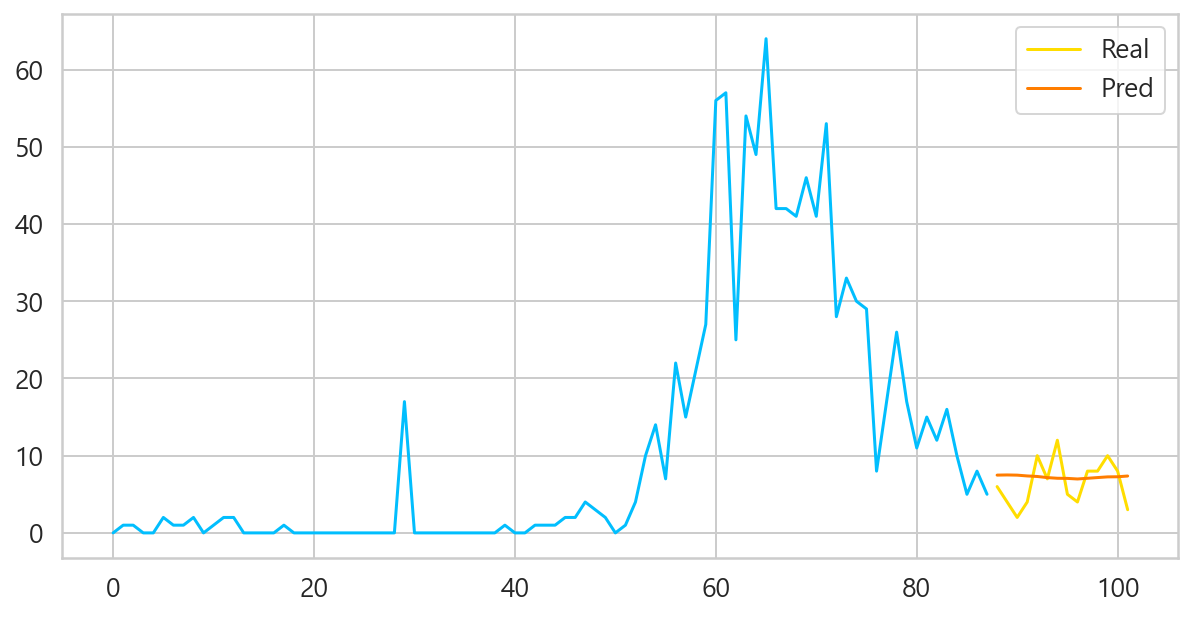

In [353]:
plt.figure(figsize=(10,5))
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
#plt.xlim(70)
plt.legend()

In [360]:
# 모델 저장
#PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
PATH = './models/{6}_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs, score.round(2))

torch.save(model, PATH)

In [65]:
# 모델 불러오기
#PATH = './models/score84_n_features_10_n_hidden_64_n_layers_4_lr_0.0001_seq_length_1_num_epochs_250.pth'
model = torch.load(PATH)
#model.eval()

# Use all data for training

In [363]:
# X변수들과 y변수 구분
X_all = df[X_cols]
y_all = df['target']

In [364]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [365]:
y_all

array([0.      , 0.015625, 0.015625, 0.      , 0.      , 0.03125 ,
       0.015625, 0.015625, 0.03125 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.      , 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.265625,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.015625, 0.      , 0.      ,
       0.015625, 0.015625, 0.015625, 0.03125 , 0.03125 , 0.0625  ,
       0.046875, 0.03125 , 0.      , 0.015625, 0.0625  , 0.15625 ,
       0.21875 , 0.109375, 0.34375 , 0.234375, 0.328125, 0.421875,
       0.875   , 0.890625, 0.390625, 0.84375 , 0.765625, 1.      ,
       0.65625 , 0.65625 , 0.640625, 0.71875 , 0.640625, 0.828125,
       0.4375  , 0.515625, 0.46875 , 0.453125, 0.125   , 0.265625,
       0.40625 , 0.265625, 0.171875, 0.234375, 0.1875  , 0.25    ,
       0.15625 , 0.078125, 0.125   , 0.078125, 0.09375 , 0.062

In [366]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (102, 331)
y_all :  (102,)


In [367]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [368]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=200, lr=lr)

Epoch 0 train loss: 0.17539790272712708
Epoch 10 train loss: 0.15404736995697021
Epoch 20 train loss: 0.13385634124279022
Epoch 30 train loss: 0.11370143294334412
Epoch 40 train loss: 0.09108830988407135
Epoch 50 train loss: 0.066629558801651
Epoch 60 train loss: 0.043497975915670395
Epoch 70 train loss: 0.02761008031666279
Epoch 80 train loss: 0.019479405134916306
Epoch 90 train loss: 0.01467522606253624
Epoch 100 train loss: 0.010669838637113571
Epoch 110 train loss: 0.008376437239348888
Epoch 120 train loss: 0.007516344543546438
Epoch 130 train loss: 0.007317710667848587
Epoch 140 train loss: 0.007220922037959099
Epoch 150 train loss: 0.007144618779420853
Epoch 160 train loss: 0.007093616761267185
Epoch 170 train loss: 0.0070495582185685635
Epoch 180 train loss: 0.007021334487944841
Epoch 190 train loss: 0.006998465396463871


# Predicting future cases

In [370]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [371]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [372]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

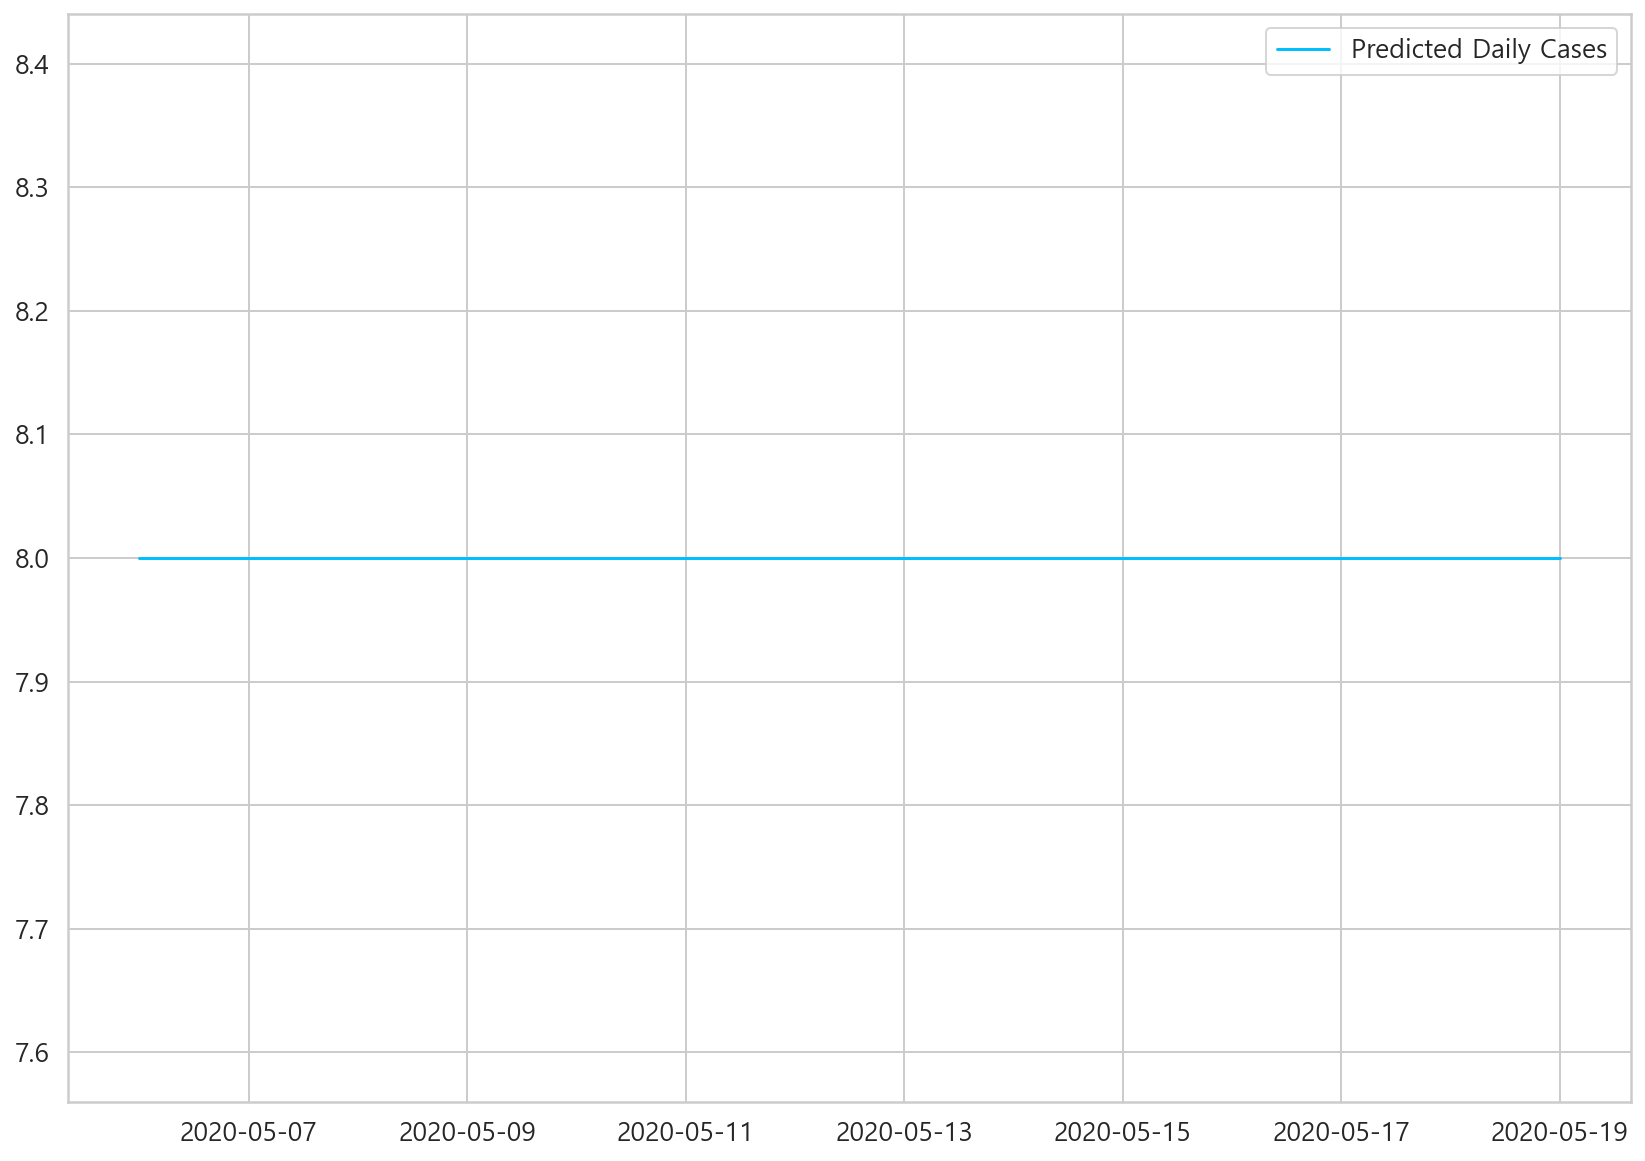

In [373]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [374]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [375]:
preds_

,0
2020-05-06,8
2020-05-07,8
2020-05-08,8
2020-05-09,8
2020-05-10,8
2020-05-11,8
2020-05-12,8
2020-05-13,8
2020-05-14,8
2020-05-15,8


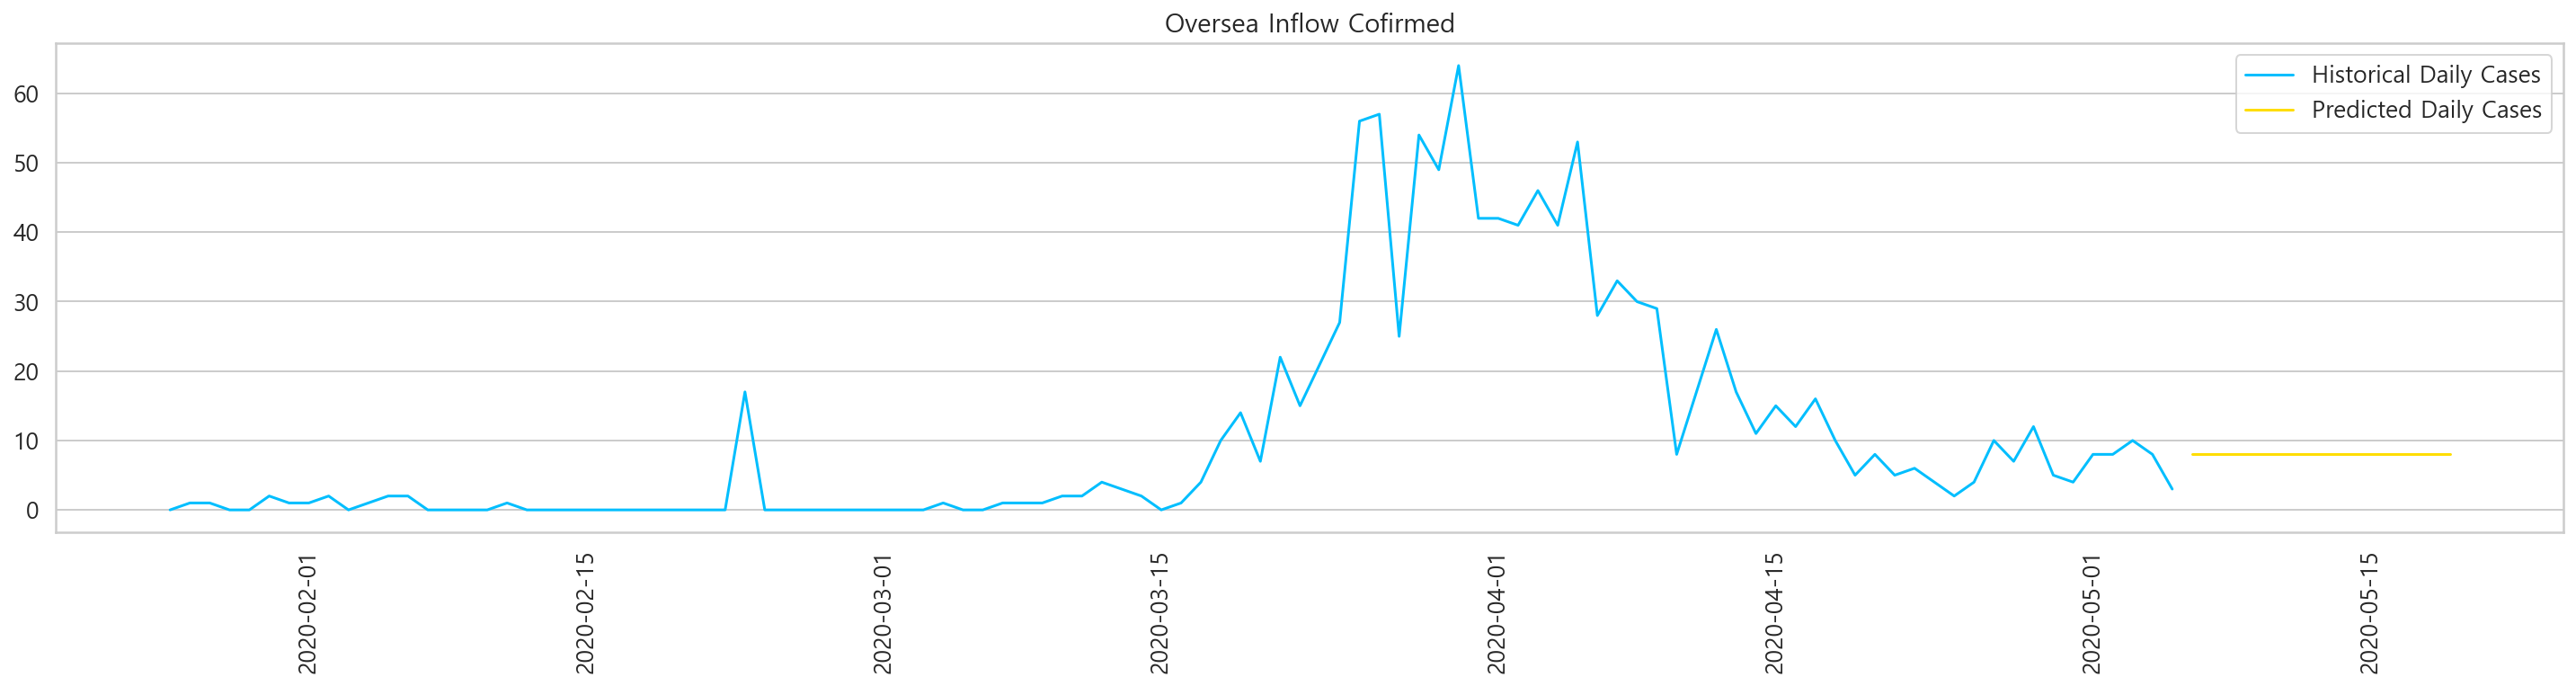

In [376]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();